Notebook for illustration on building a linear regression model on the data retrieved in batches using **ObjectStorageDataset(osds)** on local filesystem (Windows). 

Run the notebook from any local machine and set `glob` in `ObjectStorageDataset` class to the `PATH` of directory where the file resides on the machine.

 ### Install required packages, and restart the kernel.

In [10]:
!pip install osds

### Import required packages

In [11]:
import numpy as np

import torch as pt
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import osds
from osds.utils import ObjectStorageDataset

### This notebook uses the [Concrete Compressive Strength Dataset](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength) to illustrate the linear regression model using OSDS to read the data. 

The dataset consists of 9 quantitative attributes of which 7 attributes explain the ingredients, 1 attribute provides information about age, and the last attribute is the output, concrete compressive strength, which is a highly nonlinear function of age and ingredients.

The attributes follow the naming pattern of Name - DataType - Measurement - Description. The first 8 attributes are considered as input variables and the last attribute is considered to be the output variable.




### In osds,  ``ObjectStorageDataset`` class allows you to extract the data from a csv file in batches.

To retrieve the data from local filesystem, we specify the glob starting with ``file://``. Other forms of data retrieval from cloud services can be found [here](https://osds.readthedocs.io/en/latest/Introduction.html#intiate-url-file-path).

To pre-load partitions from object storage to memory, set ``eager_load_batches=True``. 

When no argument is specified to ``eager_load_batches``, datasets originating from local filesystem and those fit in cluster memory are pre-loaded to cache. 


In [12]:
batch_size = 10
concrete_data_ds = ObjectStorageDataset(glob="file://C:\\Users\\dilee\\osds\\data\\ccs_dataset\\concrete_data.csv",
                                        batch_size=batch_size,
                                        eager_load_batches=False)

In [13]:
concrete_data_iter = iter(DataLoader(concrete_data_ds, batch_size=None)) # Create an iterable object of the dataset
batch = next(concrete_data_iter)

The dataset has 9 columns of which the last column is treated as label for the model, and the rest are treated as features.

In [14]:
concrete_data_size = len(concrete_data_ds.df.index) # number of observations in the dataset
input_size = len(concrete_data_ds.df.columns[:-1]) # number of features

Create a LinearRegressionModel class

In [15]:
# Create LinearRegressionModel Class
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, X):
        return self.linear(X)

Instantiate Model Class, loss, and optimizer.

In [16]:
pt.manual_seed(50)
device = 'cuda:0' if pt.cuda.is_available() else 'cpu'
model = LinearRegressionModel(input_size, 1).double().to(device)
loss_fn = nn.MSELoss(reduction='mean')
LEARNING_RATE = 1e-03
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
losses = []
N_EPOCHS = 1000
for epoch in range(N_EPOCHS):
    running_loss = 0.
    for i in range(int(concrete_data_size/batch_size)):
        batch = next(concrete_data_iter)
        features, target = batch[:,:8].to(device), batch[:,8].to(device)
        
        yhat = model(features).view(-1, batch_size)
        loss = loss_fn(yhat, target)
        loss.backward()    

        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()
        
        if i % int(concrete_data_size/batch_size) == 102:    # print every 103 mini-batches
            losses.append(running_loss / int(concrete_data_size/batch_size))
            if epoch % 100 == 99: # print every 100 epochs
                print('[%d, %5d] \t loss: %.3f' %(epoch + 1, i + 1, running_loss / int(concrete_data_size/batch_size)))

Text(0.5, 1.0, 'Training Curve')

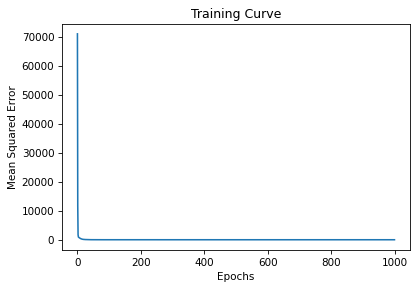

In [19]:
plt.subplots(dpi = 75)
plt.plot(range(N_EPOCHS), losses)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Curve")

<div class="alert alert-info"><h4>Note</h4><p>
  
 - Scaling/Centering can be especially helpful when the modeling requires the inclusion of any interaction terms or derived columns, to avoid multi-collinearity. Scaling the variables with a factor $a$ scales corresponding $\hat{\beta}$ by a factor $\frac{1}{a}$, and hence it is clearly not necessary to scale any of the variables in this case.    
 - **NaN/Inf** gradient updates could sometimes occur because of very large loss.

 - It is better to keep the learning rate small when the inputs are not standardized. Else, gradient explosion could happen and the model parameters would be NaN. 
    
     - **If you are keen to observe this kind of scenario, try it yourself by changing the optimizer to SGD in the above model.**</p></div> 